In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from  torch.utils.data import Dataset, DataLoader

In [2]:
seq_length = 7

In [5]:
# Q1. "데이터 불러오기 - "stock_daily.csv"을 불러오세요.
df = pd.read_csv("data/stock_daily.csv")

# 첫 번째 행을 열 이름으로 설정
df.columns = ["Open", "High", "Low", "Volume", "Close"]

df = df.apply(pd.to_numeric, errors='coerce')
# Q2a. 데이터를 역순으로 정렬하고, 전체 데이터의 70% 학습, 30% 테스트에 사용하세요.
# Q2b. 단, 테스트에 사용될 데이터에는 7일간의 데이터가 포함되지 않아야 합니다.
df_reversed = df[::-1].reset_index(drop=True)
print(df.info(), df.head())

train_index =int(0.7 * len(df_reversed))

train_df = df_reversed[:train_index]
test_df = df_reversed[train_index:]
test_df = test_df[:-seq_length]



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    732 non-null    float64
 1   High    732 non-null    float64
 2   Low     732 non-null    float64
 3   Volume  732 non-null    int64  
 4   Close   732 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 28.7 KB
None          Open        High         Low   Volume       Close
0  828.659973  833.450012  828.349976  1247700  831.659973
1  823.020020  828.070007  821.655029  1597800  828.070007
2  819.929993  824.400024  818.979980  1281700  824.159973
3  819.359985  823.000000  818.469971  1304000  818.979980
4  819.000000  823.000000  816.000000  1053600  820.450012


In [9]:
test_df.tail()

,Open,High,Low,Volume,Close
720,802.989990,806.000000,800.369995,1460400,801.489990
721,799.700012,801.669983,795.250000,1174200,801.340027
722,803.989990,810.500000,801.780029,1235200,806.969971
723,807.000000,811.840027,803.190002,1155300,808.380005
724,809.510010,810.659973,804.539978,989700,809.559998


In [10]:
# Q3. MinMaxScaler를 사용해서 학습과 테스트 데이터를 전처리하세요.
# Q3a. 학습 데이터
scaler_x = MinMaxScaler()
scaler_x.fit(train_df.iloc[:, :-1])
train_df.iloc[:, :-1] =scaler_x.transform(train_df.iloc[:, :-1])
test_df.iloc[:, :-1] =scaler_x.transform(test_df.iloc[:, :-1])

# Q3b. 테스트 데이터
scaler_y = MinMaxScaler()
scaler_y.fit(train_df.iloc[:, [-1]])

train_df.iloc[:, -1]  = scaler_y.transform(train_df.iloc[:, [-1]])
test_df.iloc[:, -1] = scaler_y.transform(test_df.iloc[:, [-1]])








In [11]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch = 100


def build_dataset(time_series, seq_length):
    X_data = []
    Y_data = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i : i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]
        X_data.append(_x)
        Y_data.append(_y)
    return np.array(X_data), np.array(Y_data)


X_train, y_train = build_dataset(np.array(train_df), seq_length)
X_test, y_test = build_dataset(np.array(test_df), seq_length)

# Q4. 텐서로 변환하세요.
# dataset =
# dataloader =

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)



train_loader = DataLoader(train_dataset, batch_size=batch , shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch , shuffle=False)

In [12]:
print("X_train_tensor shape:", X_train_tensor.shape)

X_train_tensor shape: torch.Size([505, 7, 5])


In [13]:
print("X_test_tensor shape:", X_test_tensor.shape)

X_test_tensor shape: torch.Size([206, 7, 5])


In [19]:
# 설정값
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
nb_epochs = 100


class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers

        # Q5. 아래 두 레이어를 작성하세요.
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,  batch_first=True  )
        self.fc = nn.Linear(in_features=hidden_dim,  out_features=output_dim )





    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.layers, self.seq_len, self.hidden_dim),
            torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        )

    # Q6. forward 메서드를 작성하세요.
    def forward(self, x):
         x, _ = self.lstm(x)
         x = self.fc(x[:, -1])
         return x

In [20]:
def train_model(model, train_df, num_epochs=None, lr=None, verbose=10, patience=10):
    nb_epochs = num_epochs
    train_hist = np.zeros(nb_epochs)
    # Q7. MSELoss, Adam을 설정하세요.
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        for batch_idx, samples in enumerate(train_df):
            x_train, y_train = samples
            model.reset_hidden_state()
            outputs = model(x_train)
            loss = criterion(outputs, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_cost += loss / total_batch
        train_hist[epoch] = avg_cost
        if epoch % verbose == 0:
            print("Epoch:", "%04d" % (epoch), "train loss :", "{:.4f}".format(avg_cost))

        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            # loss가 커졌다면 early stop
            if train_hist[epoch - patience] < train_hist[epoch]:
                print("\n Early Stopping")
                break

    return model.eval(), train_hist

In [30]:
import torch.nn as nn
import torch.optim as optim
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1)
model, train_hist = train_model(
    net,train_loader, num_epochs=nb_epochs, lr=learning_rate, verbose=20, patience=10
)

Epoch: 0000 train loss : 0.5965
Epoch: 0020 train loss : 0.0019
Epoch: 0040 train loss : 0.0018
Epoch: 0060 train loss : 0.0016

 Early Stopping


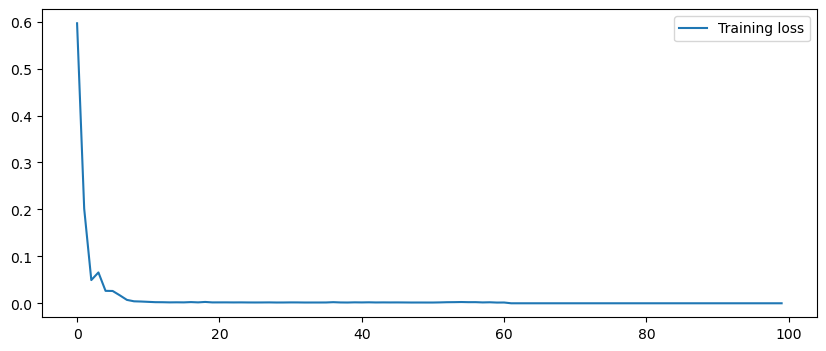

In [31]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [32]:
# 모델 저장
PATH = "stock_daily2_.pth"
torch.save(model.state_dict(), PATH)

# 불러오기
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

C:\Users\user\AppData\Local\Temp\ipykernel_13708\1810756330.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH), strict=False)


Net(
  (lstm): LSTM(5, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
# 예측 테스트
with torch.no_grad():
    pred = []
    for pr in range(len(X_test_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(X_test_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    y_test_inverse = scaler_y.inverse_transform(y_test_tensor)


def MAE(true, pred):
    return np.mean(np.abs(true - pred))


print("MAE SCORE : ", MAE( y_test_inverse,pred_inverse))

MAE SCORE :  11.48063392582683
